In [30]:
import torch
import gc
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

from EVO import LogisticRegression, DeepNeuralNetwork, EvolutionOptimizer, GradientDescentOptimizer

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: mps


In [3]:
def classification_data(n_points=1000, p_dims=2, noise=0.2, add_bias=True):
    torch.manual_seed(0)
    X = torch.randn(n_points, p_dims)
    true_w = torch.randn(p_dims + 1)
    if add_bias:
        X_with_bias = torch.cat([X, torch.ones(n_points, 1)], dim=1)
        logits = X_with_bias @ true_w
    else:
        logits = X @ true_w[:-1] + true_w[-1]
    probs = torch.sigmoid(logits)
    y = (probs + noise * torch.randn(n_points)).clamp(0, 1).round()
    return (X_with_bias if add_bias else X).float(), y.float()


In [4]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    y = y.to(y_pred.device)  # Match device
    return (y_pred == y).float().mean().item()


In [5]:
def run_experiment(num_parents_list, model_class, optimizer_class, X, y):
    results = {}
    for num_parents in num_parents_list:
        print(f"\nTesting with {num_parents} parents...")

        model = model_class()
        optimizer = optimizer_class(model)
        optimizer.set_population_size(50)
        optimizer.set_mutation_rate(0.5)
        optimizer.set_mutation_intensity(0.3)
        model.set_optimizer(optimizer)

        losses = []
        accs = []
        diversities = []

        max_iter = 300
        for i in range(max_iter):
            acc = accuracy(model, X, y)
            loss = model.loss(X, y).item()
            diversity = optimizer.compute_diversity(metric = "euclidean").item()

            losses.append(loss)
            accs.append(acc)
            diversities.append(diversity)

            if acc > 0.99:
                print(f"Early stop at iter {i} with acc {acc:.3f}")
                break

            optimizer.step(X, y, num_parents=num_parents)

            if i % 100 == 0:
                print(f"Iter {i}: loss {loss:.4f}, acc {acc:.4f}, diversity {diversity:.4f}")

        final_loss = losses[-1]
        print(f"Final loss with {num_parents} parents: {final_loss:.4f}")
        
        results[num_parents] = (losses, accs, diversities)

    return results


In [6]:
def plot_results(results):
    plt.figure(figsize=(12, 5))
    
    for num_parents, (losses, accs) in results.items():
        plt.plot(accs, label=f"{num_parents} parents")
    
    plt.title("Accuracy over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
X, y = classification_data(p_dims=2, noise=0.2, n_points=300, add_bias=False)

y = y.long()  

num_parents_list = [0, 1, 2, 3, 5, 10]
results = run_experiment(num_parents_list, lambda: DeepNeuralNetwork([2, 10, 2]), EvolutionOptimizer, X, y)



Testing with 0 parents...
Iter 0: loss 0.6079, acc 0.6700, diversity 0.0000
Iter 100: loss 0.2961, acc 0.8733, diversity 2.9197
Iter 200: loss 0.2961, acc 0.8733, diversity 2.9584
Final loss with 0 parents: 0.2961

Testing with 1 parents...
Iter 0: loss 1.3892, acc 0.1433, diversity 0.0000
Iter 100: loss 0.2595, acc 0.9233, diversity 4.9949
Iter 200: loss 0.2595, acc 0.9233, diversity 5.5162
Final loss with 1 parents: 0.2565

Testing with 2 parents...
Iter 0: loss 0.4565, acc 0.8733, diversity 0.0000
Iter 100: loss 0.2668, acc 0.9200, diversity 8.0457
Iter 200: loss 0.2668, acc 0.9200, diversity 8.7269
Final loss with 2 parents: 0.2657

Testing with 3 parents...
Iter 0: loss 0.6194, acc 0.7667, diversity 0.0000
Iter 100: loss 0.2658, acc 0.9200, diversity 8.7939
Iter 200: loss 0.2658, acc 0.9200, diversity 8.7175
Final loss with 3 parents: 0.2658

Testing with 5 parents...
Iter 0: loss 0.7873, acc 0.4533, diversity 0.0000
Iter 100: loss 0.2598, acc 0.9000, diversity 7.9550
Iter 200: l

In [10]:
for num_parents, (losses, accs, diversities) in results.items():
    print(f"{num_parents} parents → Final loss: {losses[-1]:.4f}, Final acc: {accs[-1]:.4f}, Final diversity: {diversities[-1]:.4f}")


0 parents → Final loss: 0.2961, Final acc: 0.8733, Final diversity: 2.9419
1 parents → Final loss: 0.2565, Final acc: 0.9167, Final diversity: 6.4722
2 parents → Final loss: 0.2657, Final acc: 0.9200, Final diversity: 8.6953
3 parents → Final loss: 0.2658, Final acc: 0.9200, Final diversity: 8.8287
5 parents → Final loss: 0.2598, Final acc: 0.9000, Final diversity: 8.8498
10 parents → Final loss: 0.2536, Final acc: 0.9067, Final diversity: 8.1135


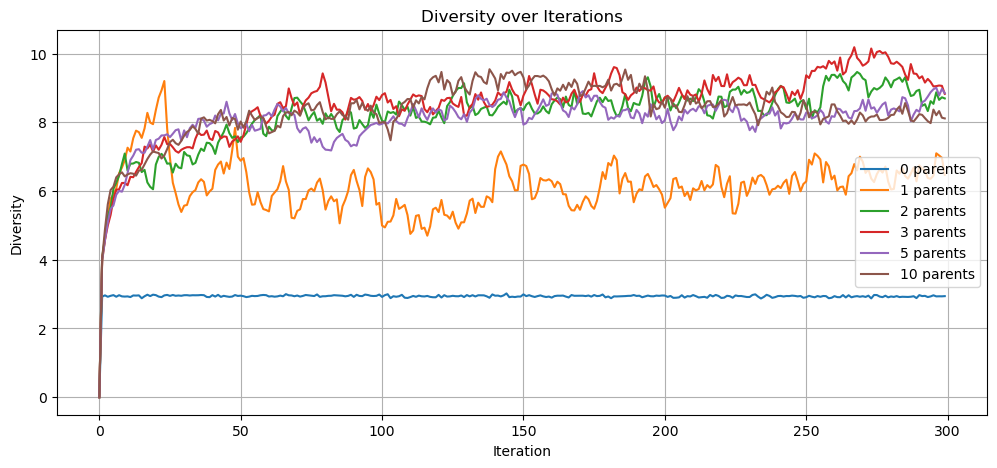

In [14]:
def plot_diversity(results):
    plt.figure(figsize=(12, 5))
    for num_parents, (_, _, diversities) in results.items():
        plt.plot(diversities, label=f"{num_parents} parents")
    plt.title("Diversity over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Diversity")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_diversity(results)


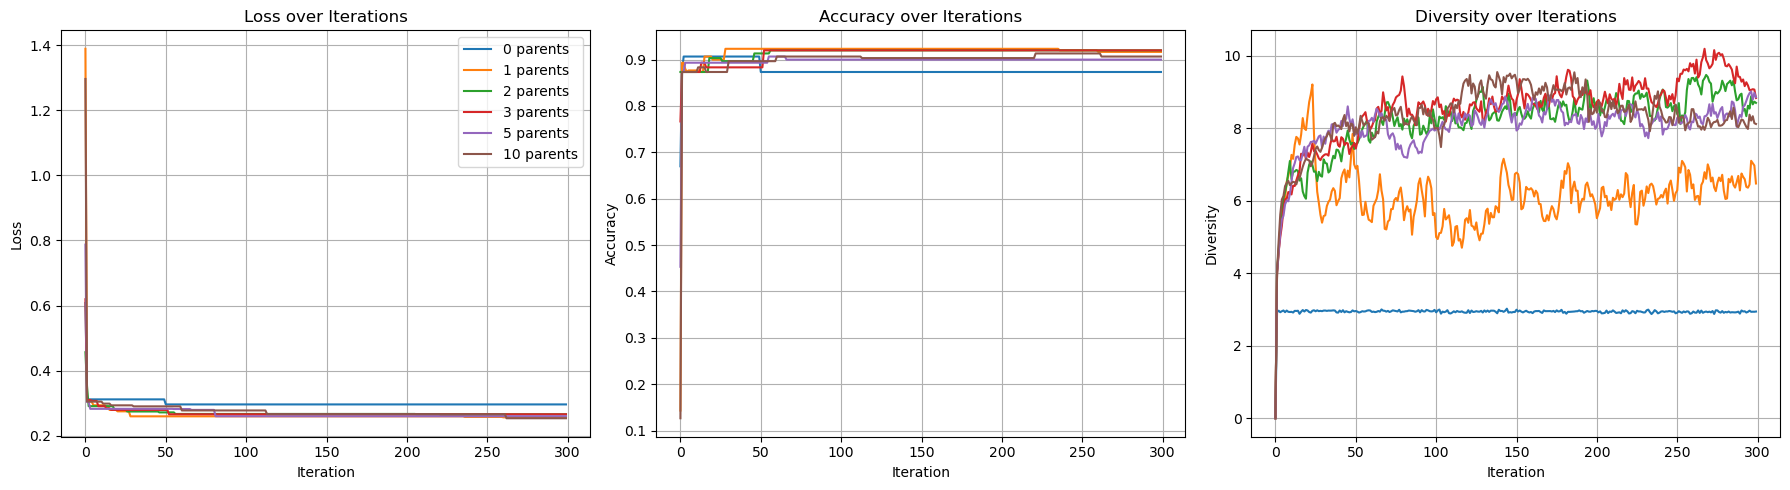

In [15]:
def plot_all_metrics(results):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for num_parents, (losses, accs, diversities) in results.items():
        axs[0].plot(losses, label=f"{num_parents} parents")
        axs[1].plot(accs, label=f"{num_parents} parents")
        axs[2].plot(diversities, label=f"{num_parents} parents")

    axs[0].set_title("Loss over Iterations")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)

    axs[1].set_title("Accuracy over Iterations")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)

    axs[2].set_title("Diversity over Iterations")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Diversity")
    axs[2].grid(True)

    axs[0].legend()
    plt.tight_layout()
    plt.show()
plot_all_metrics(results)

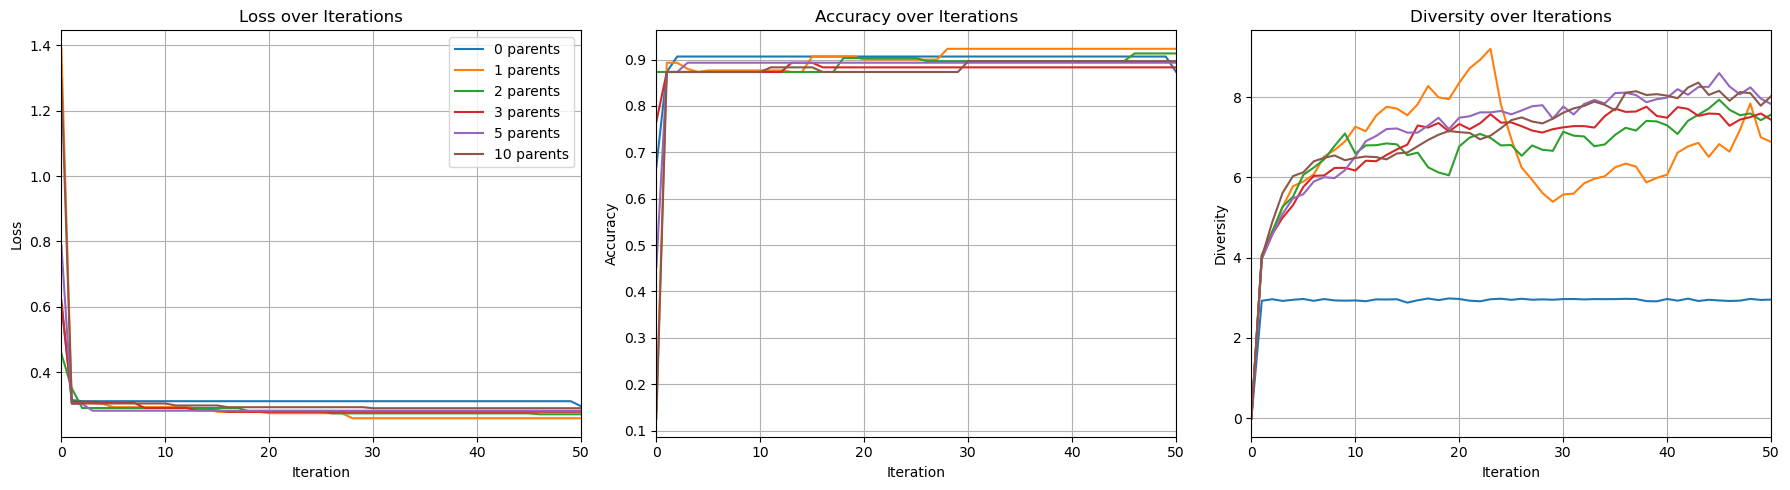

In [13]:
def plot_all_metrics(results):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for num_parents, (losses, accs, diversities) in results.items():
        axs[0].plot(losses[:51], label=f"{num_parents} parents")
        axs[1].plot(accs[:51], label=f"{num_parents} parents")
        axs[2].plot(diversities[:51], label=f"{num_parents} parents")

    axs[0].set_title("Loss over Iterations")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlim(0, 50)
    axs[0].grid(True)

    axs[1].set_title("Accuracy over Iterations")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_xlim(0, 50)
    axs[1].grid(True)

    axs[2].set_title("Diversity over Iterations")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Diversity")
    axs[2].set_xlim(0, 50)
    axs[2].grid(True)

    axs[0].legend()
    plt.tight_layout()
    plt.show()
plot_all_metrics(results)

Load in MNIST data:

In [2]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from EVO import DeepNeuralNetwork, EvolutionOptimizer, LogisticRegression

device = torch.device("cuda" if torch.cuda.is_available()
                      else ("mps" if torch.backends.mps.is_available() else "cpu"))

def flatten_tensor(x):
    return x.view(-1)

transform = transforms.Compose([
    transforms.ToTensor(),                        # (1, 28, 28) in [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),   # standard MNIST normalisation
    transforms.Lambda(flatten_tensor),       # flatten to (784,)
])



train_ds = Subset(
    datasets.MNIST(".", train=True, download=True, transform=transform),
    range(1000)
)
test_ds = Subset(
    datasets.MNIST(".", train=False, download=True, transform=transform),
    range(1000)
)

train_loader = DataLoader(
    train_ds, batch_size=256, shuffle=True,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=1000,
    num_workers=0, pin_memory=True
)

Set up the model

Evolution Loop

In [4]:
num_parents_list = [0, 1, 2, 5, 10]


for num_parents in num_parents_list:
    print(f"\nTesting with {num_parents} parents...")

    model = DeepNeuralNetwork([784, 32, 10])
    model.use_diversity_loss = True
    model.diversity_coeff   = 0.2

    optimizer = EvolutionOptimizer(model)
    optimizer.set_population_size(100)
    optimizer.use_backprop = False
    optimizer.set_survivors_ratio(0.1)
    optimizer.set_fitness_ratio(0.5)
    optimizer.set_sneaker_prob(0.01)
    optimizer.set_sneakers_ratio(0.1)
    optimizer.set_mutation_intensity(0.05)
    optimizer.mutation_rate = 0.05
    optimizer.set_num_parents(num_parents)


    losses = []
    accuracies = []
    diversities = []
    for gen in range(5000):
        for X, y in train_loader:
            optimizer.step(X, y)
        # optionally decay diversity over time
        model.diversity_coeff *= 0.9

        # evaluate on test set
        correct = total = 0
        with torch.no_grad():
            for X, y in test_loader:
                preds = model.predict(X.to(device))
                correct += (preds == y.to(device)).sum().item()
                total   += y.size(0)
        acc = 100 * correct / total
        losses.append(model.loss(X, y).item())
        diversities.append(optimizer.compute_diversity(metric = "euclidean").item())
        accuracies.append(acc)
        if gen%25 == 0:
            print(f"Gen {gen+1:03d} → Test Acc: {acc:.2f}%, Loss: {losses[-1]:.4f}, Diversity: {diversities[-1]:.4f}")
    print(f"Final Test Acc: {acc:.2f}%, Loss: {losses[-1]:.4f}, Diversity: {diversities[-1]:.4f}")


Testing with 0 parents...
Gen 001 → Test Acc: 7.90%, Loss: -12.9551, Diversity: 65.1306
Gen 026 → Test Acc: 10.50%, Loss: 10.1252, Diversity: 65.1450


KeyboardInterrupt: 